# Traitement des données :

Dans un premier temps, à partir de ma base brute **"DVF_80.csv"** je devais retirer un grand nombre de colonnes qui ne me servait pas dans mon étude de la valeur. Le choix a été minutieux, de façon à ne pas retirer de potentiel features importantes. 

Pour ce faire, j'ai utilisé MySQL et SQLite. MySQL me permettait de faire de plus grosses requêtes comparées à SQLite qui ne peut DROP qu'une colonne à la fois par exemple : 

[SQL Drop command](SQL/SQL_Drop.png)

Dans un second temps, j'ai retiré toutes les natures de mutation qui sont autres que des ventes.

[SQL Delete != ventes](SQL/SQL_Delete_first_step.png)

Par la suite, j'ai supprimé un ensemble de lignes comprenant des NULL, ou bien des types de bien qui ne correspondait pas.

[SQL Delete ...](SQL/SQL_Delete_other.png)

Une fois mes données retraitées, je peux procéder à l'analyse.



## Analyse avec Python

In [18]:
# Import
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
# Possibilité d'afficher les données de base pour comparer

# df = pd.read_csv("Data/DVF_80.csv")
# df.head()

# print(df.shape)

# print(df.describe(include="all"))


In [20]:
df_step2 = pd.read_csv("Data/DVF_80_retraitees.csv")
df_step2.head()

,id_mutation,nature_mutation,valeur_fonciere,code_postal,type_local,surface_reelle_bati
0,2023-432445,Vente,163500.0,80580,Maison,85
1,2023-432446,Vente,190500.0,80480,Maison,59
2,2023-432447,Vente,365000.0,80000,Local industriel. commercial ou assimilé,392
3,2023-432447,Vente,365000.0,80000,Appartement,51
4,2023-432448,Vente,220000.0,80150,Maison,84


In [21]:
# Affichage du nombre de ligne et de colonne
print(df_step2.shape)

# Affichage des informations statistiques essentielles
print(df_step2.describe(include="all"))

# Affichage des colonnes qui contiennent des valeurs null --> normalement il ne devrait pas en avoir après mon retraitement de données en SQL
df_step2.isnull().any()

(4397, 6)
        id_mutation nature_mutation  valeur_fonciere   code_postal type_local  \
count          4397            4397     4.397000e+03   4397.000000       4397   
unique         3393               1              NaN           NaN          3   
top     2023-432496           Vente              NaN           NaN     Maison   
freq             33            4397              NaN           NaN       3079   
mean            NaN             NaN     2.074016e+05  80283.294292        NaN   
std             NaN             NaN     3.380510e+05    243.745282        NaN   
min             NaN             NaN     1.000000e+00  80000.000000        NaN   
25%             NaN             NaN     9.700000e+04  80090.000000        NaN   
50%             NaN             NaN     1.500000e+05  80210.000000        NaN   
75%             NaN             NaN     2.247500e+05  80460.000000        NaN   
max             NaN             NaN     7.380000e+06  80980.000000        NaN   

        surface_r

id_mutation            False
nature_mutation        False
valeur_fonciere        False
code_postal            False
type_local             False
surface_reelle_bati    False
dtype: bool

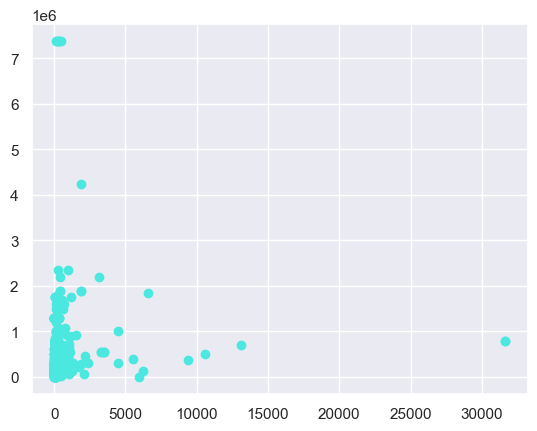

In [22]:
# Affichage du nuage de point pour visualiser la tendance

plt.scatter(df_step2.iloc[:, 5], df_step2.iloc[:, 2], color="#4BE8E0")
plt.show()

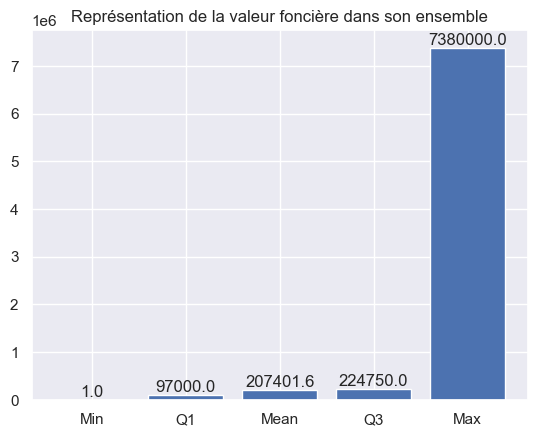

In [23]:
# Affichage d'un graphique à barre mettant en avant les éléments principaux comme les quartiles, les min / max et la moyenne

max_value = df_step2['valeur_fonciere'].max()
min_value = df_step2['valeur_fonciere'].min()
mean_value = round(df_step2['valeur_fonciere'].mean(),2)
q1 = df_step2['valeur_fonciere'].quantile(0.25)
q3 = df_step2['valeur_fonciere'].quantile(0.75)

plt.bar(['Min', 'Q1', 'Mean', 'Q3', 'Max'], [min_value, q1, mean_value, q3, max_value])

plt.text(0, min_value, str(min_value), ha='center', va='bottom')
plt.text(1, q1, str(q1), ha='center', va='bottom')
plt.text(2, mean_value, str(mean_value), ha='center', va='bottom')
plt.text(3, q3, str(q3), ha='center', va='bottom')
plt.text(4, max_value, str(max_value), ha='center', va='bottom')

plt.title("Représentation de la valeur foncière dans son ensemble")

plt.show()

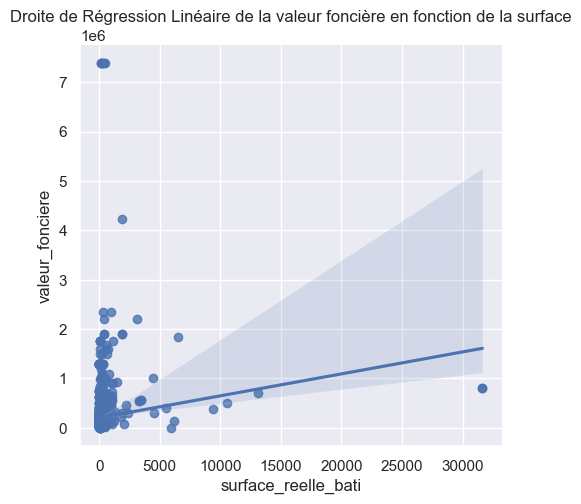

In [24]:
# Traçage d'une droite de régression linéaire lié à mon nuage de point

sns.set(style="darkgrid")
sns.lmplot(x="surface_reelle_bati", y="valeur_fonciere", data=df_step2)

plt.title("Droite de Régression Linéaire de la valeur foncière en fonction de la surface")

plt.show()

Malgré des valeurs extrêmes et un regroupement de données, je décide de partir sur un modèle de régression linéaire. J'imagine qu'une tendance va ressortir de la superficie des biens et du type de bien, permettant d'envisager sa valeur.

## Machine Learning --> Modèle de régression linéaire

In [25]:
# Rappel des colonnes

df_step2.head()

,id_mutation,nature_mutation,valeur_fonciere,code_postal,type_local,surface_reelle_bati
0,2023-432445,Vente,163500.0,80580,Maison,85
1,2023-432446,Vente,190500.0,80480,Maison,59
2,2023-432447,Vente,365000.0,80000,Local industriel. commercial ou assimilé,392
3,2023-432447,Vente,365000.0,80000,Appartement,51
4,2023-432448,Vente,220000.0,80150,Maison,84


In [26]:
# Séparation de la variable cible Y et de la variable "features" X

print("Separating labels from features...")
feature_list=["surface_reelle_bati", "type_local"]
X = df_step2.loc[:,feature_list]
y = df_step2.loc[:,"valeur_fonciere"]
print("...Done.")
print()

Separating labels from features...
...Done.



In [27]:
# Division du dataset en Train / Test

print("Splitting dataset into train set and test set...")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

print("...Done.")  

# Visualisation de mon X_train

print(X_train.head())

Splitting dataset into train set and test set...
...Done.
      surface_reelle_bati   type_local
4332                   71  Appartement
3245                   50       Maison
980                    83       Maison
1593                   89       Maison
3870                   28  Appartement


In [28]:
### Training pipeline ###
print("--- Training pipeline ---")
print()  

# Encodage des "categorical features" et standardisation des "numeric features"

print("#### X_train BEFORE preprocessing ####")
print(X_train.head())
print()

print("Encoding categorical features and standardizing numerical features...")

print()

numeric_features = [0]
numeric_transformer = StandardScaler()

categorical_features = [1]
categorical_transformer = OneHotEncoder(drop='first')

feature_encoder = ColumnTransformer(
    transformers=[  
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        ]
    )

X_train = feature_encoder.fit_transform(X_train)
print("...Done.")
print(X_train[:5]) 
print()

--- Training pipeline ---

#### X_train BEFORE preprocessing ####
      surface_reelle_bati   type_local
4332                   71  Appartement
3245                   50       Maison
980                    83       Maison
1593                   89       Maison
3870                   28  Appartement

Encoding categorical features and standardizing numerical features...

...Done.
[[-0.07120801  0.          0.        ]
 [-0.09638025  0.          1.        ]
 [-0.05682388  0.          1.        ]
 [-0.04963181  0.          1.        ]
 [-0.12275116  0.          0.        ]]



In [29]:
# Train model

print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, y_train) 
print("...Done.")

Train model...
...Done.


In [30]:
# Prédiction sur le training set
print("Predictions on training set...")
y_train_pred = regressor.predict(X_train)
print("...Done.")
print(y_train_pred[:5]) 
print()

Predictions on training set...
...Done.
[187282.45638321 173184.91986255 173801.54614591 173913.66001561
 186478.97365035]



In [31]:
### Testing pipeline ###
print("--- Testing pipeline ---")

# Standardisation des "numeric features"
print("Standardizing numerical features...")
print(X_test)
print()

X_test = feature_encoder.transform(X_test)

print("...Done.")
print(X_test[:5])
print()

--- Testing pipeline ---
Standardizing numerical features...
      surface_reelle_bati                                type_local
584                    72                                    Maison
499                    64                                    Maison
4287                   69                                    Maison
3348                   93                                    Maison
3573                  120  Local industriel. commercial ou assimilé
...                   ...                                       ...
1001                   50                                    Maison
3218                   19                               Appartement
977                    86                               Appartement
3401                  108                                    Maison
2224                   33                                    Maison

[880 rows x 2 columns]

...Done.
[[-0.07000933  0.          1.        ]
 [-0.07959876  0.          1.        ]
 [-0.073605

In [32]:
# Prédiction du test set

print("Predictions on test set...")
y_test_pred = regressor.predict(X_test)
print("...Done.")
print(y_test_pred[:5])
print()

Predictions on test set...
...Done.
[173596.00405145 173446.51889185 173539.9471166  173988.40259541
 528381.33306198]



In [33]:
# Calcul des performances
print("--- Assessing the performances of the model ---")

# Performances R^2 scores
print("R2 score on training set : ", regressor.score(X_train, y_train))
print("R2 score on test set : ", regressor.score(X_test, y_test))

--- Assessing the performances of the model ---
R2 score on training set :  0.10040676940836746
R2 score on test set :  0.07078312076220117
